In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
from signal_processing.base_signal_processor import BaseSignalProcessor
from signal_processing.motion_artifact_detector import MotionArtifactDetector
from signal_processing.adaptive_filter import AdaptiveFilter
from signal_processing.kalman_filter import KalmanFilter
from signal_processing.wavelet_denoiser import WaveletDenoiser
from signal_processing.pipeline import SignalProcessingPipeline

### Loading Unified Data

In [3]:
processor = BaseSignalProcessor(data_path="../data/processed/cleaned_unified_dataset.parquet")
dataset = processor.load_data()
print(dataset.head())

Loading unified dataset...
                                 bvp  label  subject_id    dataset  \
2020-01-03 08:00:00+00:00   5.673109      0           2  physionet   
2020-01-03 08:00:00+00:00   7.687833      0           2  physionet   
2020-01-03 08:00:00+00:00   1.509560      0           2  physionet   
2020-01-03 08:00:00+00:00  12.999866      0           2  physionet   
2020-01-03 08:00:00+00:00  20.798602      0           2  physionet   

                                 device skin_tone  noise_level     acc_x  \
2020-01-03 08:00:00+00:00   apple_watch      V-VI      0.05088 -0.817685   
2020-01-03 08:00:00+00:00   apple_watch      I-II      0.07712 -0.973498   
2020-01-03 08:00:00+00:00   apple_watch    III-IV      0.06400 -1.054134   
2020-01-03 08:00:00+00:00  galaxy_watch    III-IV      0.09600 -1.000000   
2020-01-03 08:00:00+00:00  galaxy_watch      V-VI      0.07632 -1.000000   

                               acc_y     acc_z  
2020-01-03 08:00:00+00:00 -62.628226  4.996602

In [4]:
import numpy as np

In [5]:
def _robust_normalize(data: np.ndarray) -> np.ndarray:
    """Enhanced normalization with fallback"""
    data = np.nan_to_num(data, nan=np.median(data))
        
    # Fallback to std if IQR is zero
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    if iqr < 1e-6:
        std = np.std(data) + 1e-6
        normalized = (data - np.mean(data)) / std
    else:
        normalized = (data - np.median(data)) / iqr
        
    # Secondary clipping
    return np.clip(normalized, -3, 3)

# Compute and normalize accelerometer magnitude
dataset['acc_mag'] = np.sqrt(dataset['acc_x']**2 + dataset['acc_y']**2 + dataset['acc_z']**2)
dataset['acc_mag'] = _robust_normalize(dataset['acc_mag'].values)

### Motion Artifact Detection

In [6]:
detector = MotionArtifactDetector()
dataset = detector.detect_motion_bursts(dataset)
print(dataset[['acc_x', 'acc_y', 'acc_z', 'motion_burst']].head())

                              acc_x      acc_y     acc_z  motion_burst
2020-01-03 08:00:00+00:00 -0.817685 -62.628226  4.996602           0.0
2020-01-03 08:00:00+00:00 -0.973498 -62.739436  5.184150           0.0
2020-01-03 08:00:00+00:00 -1.054134 -62.992483  5.020381           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0


In [7]:
num_unique_motion_bursts = dataset['motion_burst'].nunique()
motion_burst_counts = dataset['motion_burst'].value_counts()
print(f"Value counts of motion_burst:\n{motion_burst_counts}")

# Check motion burst distribution
motion_burst_counts = dataset['motion_burst'].value_counts(normalize=True) * 100
print(f"Motion Burst Distribution:\n{motion_burst_counts}")


Value counts of motion_burst:
motion_burst
0.000000    5311156
0.208747        911
0.225245        184
0.359325        163
0.120694        163
             ...   
0.085190          1
0.178560          1
0.097003          1
0.293048          1
0.154376          1
Name: count, Length: 16875, dtype: int64
Motion Burst Distribution:
motion_burst
0.000000    81.027554
0.208747     0.013898
0.225245     0.002807
0.359325     0.002487
0.120694     0.002487
              ...    
0.085190     0.000015
0.178560     0.000015
0.097003     0.000015
0.293048     0.000015
0.154376     0.000015
Name: proportion, Length: 16875, dtype: float64


In [8]:
# import matplotlib.pyplot as plt
# # Visualize results
# plt.figure(figsize=(12, 6))
# plt.plot(dataset['acc_mag'], label="Accelerometer Magnitude")
# plt.plot(dataset['motion_burst'] * dataset['acc_mag'].max(), label="Motion Bursts", linestyle='--')
# plt.legend()
# plt.title("Motion Burst Detection")
# plt.show()

### Adaptive Filtering for Motion Artifact Removal

In [9]:
adaptive_filter = AdaptiveFilter()
cleaned_bvp = adaptive_filter.apply_adaptive_filter(
    noisy_signal=dataset['bvp'].values,
    reference_signal=dataset['acc_mag'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_cleaned'] = cleaned_bvp

INFO:root:Applying adaptive filtering... Input length: 6554753


KeyboardInterrupt: 

### Apply kalman filter

In [10]:
kalman_filter = KalmanFilter()
bvp_smoothed = kalman_filter.apply_kalman_filter(
    signal=dataset['bvp_cleaned'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_smoothed'] = bvp_smoothed

### Wavelet Denoising

In [11]:
# notebooks/phase3_signal_processing.ipynb

wavelet_denoiser = WaveletDenoiser()
denoised_bvp = wavelet_denoiser.apply_wavelet_denoising(dataset['bvp_smoothed'].values,motion_burst=dataset['motion_burst'].values,skin_tone=dataset['skin_tone'].iloc[0])

# Verify lengths match before assignment
assert len(denoised_bvp) == len(dataset), "Denoised signal length mismatch"

dataset['bvp_denoised'] = denoised_bvp

In [12]:
dataset.head()

,bvp,label,subject_id,dataset,device,skin_tone,noise_level,acc_x,acc_y,acc_z,acc_mag,acc_threshold,motion_burst,bvp_cleaned,bvp_smoothed,bvp_denoised
2020-01-03 08:00:00+00:00,5.673109,0,2,physionet,apple_watch,V-VI,0.05088,-0.817685,-62.628226,4.996602,20.0,20.0,0.0,3.682249,3.682249,3.611029
2020-01-03 08:00:00+00:00,7.687833,0,2,physionet,apple_watch,I-II,0.07712,-0.973498,-62.739436,5.184150,20.0,20.0,0.0,3.682249,3.682249,3.615323
2020-01-03 08:00:00+00:00,1.509560,0,2,physionet,apple_watch,III-IV,0.06400,-1.054134,-62.992483,5.020381,20.0,20.0,0.0,3.682249,3.682249,3.626758
2020-01-03 08:00:00+00:00,12.999866,0,2,physionet,galaxy_watch,III-IV,0.09600,-1.000000,-69.300000,5.000000,20.0,20.0,0.0,3.682249,3.682249,3.651145
2020-01-03 08:00:00+00:00,20.798602,0,2,physionet,galaxy_watch,V-VI,0.07632,-1.000000,-69.300000,5.000000,20.0,20.0,0.0,3.682249,3.682249,3.681871


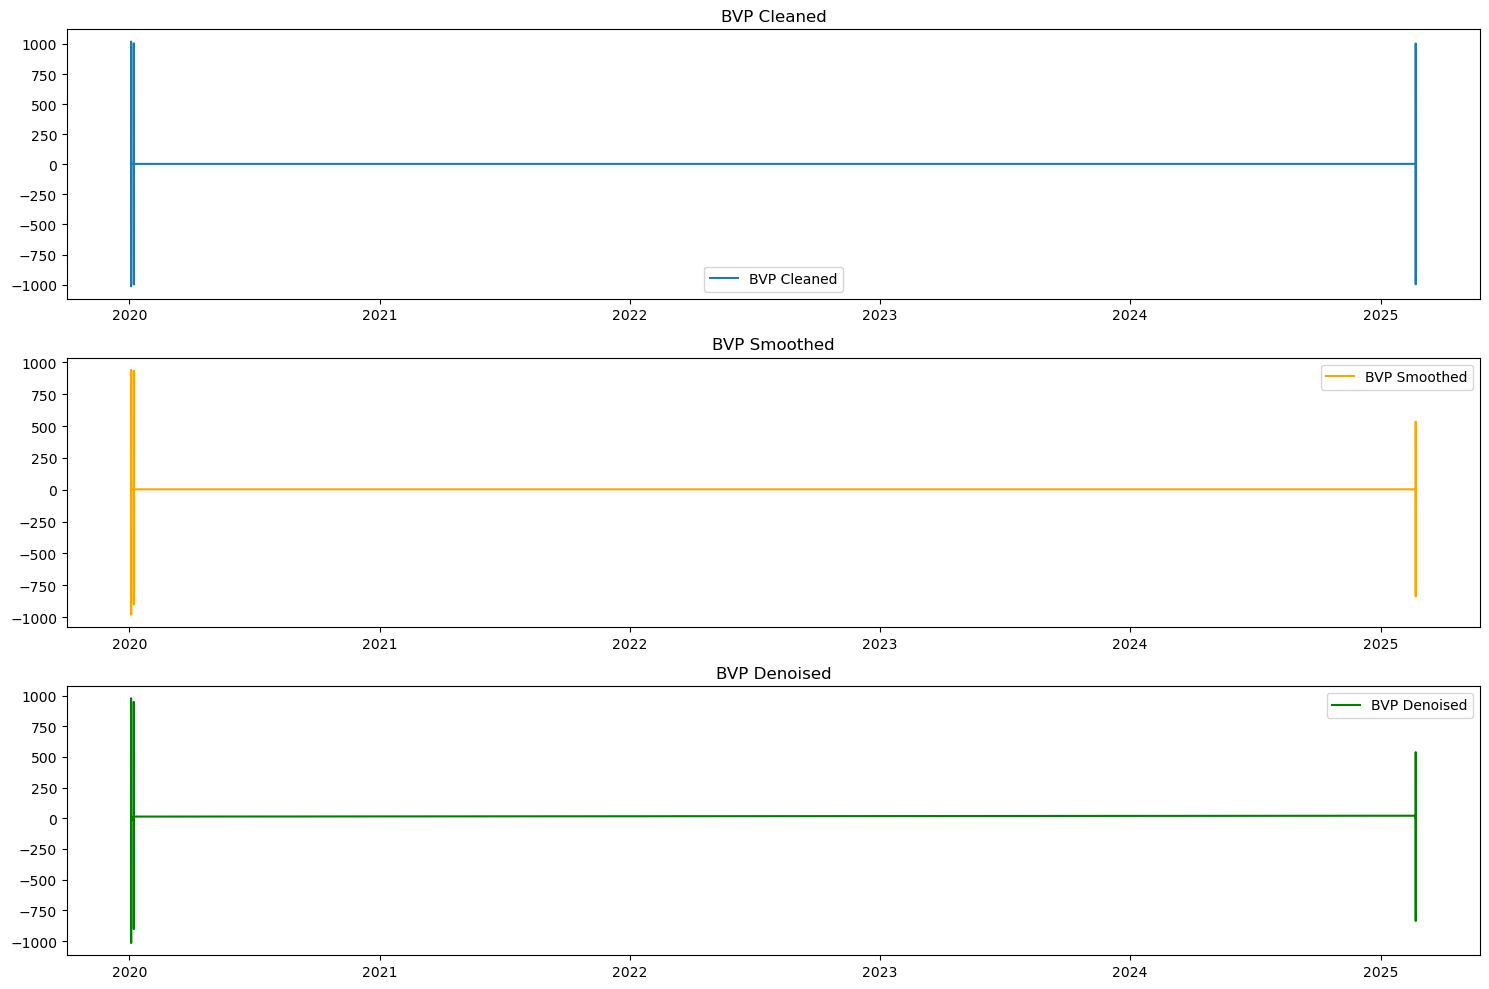

Statistical Properties:
BVP Cleaned: Mean = 3.7827737450601444, Std = 58.55515208754918
BVP Smoothed: Mean = 3.7827738533262525, Std = 34.67954771524223
BVP Denoised: Mean = 3.7827738612512847, Std = 34.7550123996447


In [13]:
import matplotlib.pyplot as plt

# Plot the signals
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(dataset.index, dataset['bvp_cleaned'], label='BVP Cleaned')
plt.title('BVP Cleaned')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(dataset.index, dataset['bvp_smoothed'], label='BVP Smoothed', color='orange')
plt.title('BVP Smoothed')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dataset.index, dataset['bvp_denoised'], label='BVP Denoised', color='green')
plt.title('BVP Denoised')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical properties
print("Statistical Properties:")
print(f"BVP Cleaned: Mean = {dataset['bvp_cleaned'].mean()}, Std = {dataset['bvp_cleaned'].std()}")
print(f"BVP Smoothed: Mean = {dataset['bvp_smoothed'].mean()}, Std = {dataset['bvp_smoothed'].std()}")
print(f"BVP Denoised: Mean = {dataset['bvp_denoised'].mean()}, Std = {dataset['bvp_denoised'].std()}")

## Runnig the Pipeline

In [14]:
import pandas as pd

In [ ]:
dataset_ = pd.read_parquet("../data/processed/cleaned_unified_dataset.parquet")
pipeline = SignalProcessingPipeline()
processed_df = pipeline.process_signal(dataset_)

INFO:root:Applying adaptive filtering... Input length: 6554753


In [ ]:
dataset.columns

Index(['bvp', 'label', 'subject_id', 'dataset', 'device', 'skin_tone',
       'noise_level', 'acc_x', 'acc_y', 'acc_z', 'acc_mag', 'motion_burst',
       'bvp_cleaned', 'bvp_smoothed', 'bvp_denoised'],
      dtype='object')

In [ ]:
# Plot downsampled comparison
downsample_factor = 100
plt.figure(figsize=(12, 6))
plt.plot(dataset['bvp'].values[::downsample_factor][:1000], 
         label='Original (Downsampled)', alpha=0.7)
plt.plot(dataset['bvp_cleaned'].values[::downsample_factor][:1000], 
         label='Cleaned (Downsampled)')
plt.title("Signal Comparison (0.3Hz Subsampling)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Signal Quality Metrics

In [ ]:
from scipy.signal import find_peaks
from fastdtw import fastdtw

class SignalQualityMetrics:
    def compute_snr(self, cleaned_signal: np.ndarray, original_signal: np.ndarray) -> float:
        """Compute SNR using original signal as reference"""
        distance, path = fastdtw(original_signal, cleaned_signal)
        aligned_cleaned = np.array([cleaned_signal[j] for i, j in path])
        
        min_length = min(len(original_signal), len(aligned_cleaned))
        return 10 * np.log10(
            np.mean(original_signal[:min_length]**2) / 
            (np.mean((aligned_cleaned[:min_length] - original_signal[:min_length])**2) + 1e-9)
        )

    def compute_artifact_density(self, motion_burst: np.ndarray) -> float:
        return 100 * np.mean(motion_burst)

In [ ]:
# Compute metrics using original BVP as reference
metrics_calculator = SignalQualityMetrics()
snr = metrics_calculator.compute_snr(
    processed_df['bvp_cleaned'].values,
    processed_df['bvp'].values  # Use original signal as reference
)
artifact_density = metrics_calculator.compute_artifact_density(processed_df['motion_burst'].values)

print(f"SNR: {snr:.2f} dB, Artifact Density: {artifact_density:.2f}%")

SNR: -67.13 dB, Artifact Density: 2.73%


## Saving cleaned data

In [ ]:
pipeline.save_cleaned_dataset(dataset, "../data/cleaned_signal_dataset")

Cleaned dataset saved to ../data/cleaned_signal_dataset
